In [4]:
"""Model for manual threshold categorization using Monte Carlo cross validation technique."""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from collections import Counter
from collections import defaultdict
from sklearn.metrics import classification_report



# File paths for the datasets
file_paths_nfl = [
    "data/historical-nfl/2018wr.csv",
    "data/historical-nfl/2019wr.csv",
    "data/historical-nfl/2020wr.csv",
    "data/historical-nfl/2021wr.csv",
    "data/historical-nfl/2022wr.csv"
]

# Load and combine the datasets
combined_data_nfl = pd.concat([pd.read_csv(path) for path in file_paths_nfl], ignore_index=True)

# Save the combined data to a new CSV file
output_path_nfl = "data/historical-nfl/combined_wr_data.csv"
combined_data_nfl.to_csv(output_path_nfl, index=False)

# Load and preprocess nfl stats
nfl_stats = pd.read_csv("data/historical-nfl/combined_wr_data.csv")
nfl_stats['nflYears'] = nfl_stats['nflYears'].astype(float)

# List of columns to normalize and average
nfl_metrics_to_normalize = ['nflRec', 'nflYds', 'nflTD', 'AP1', 'St', 'PB']

# Average the metrics by dividing by Games played
for metric in nfl_metrics_to_normalize:
    nfl_stats[metric + '_avg'] = nfl_stats[metric] / nfl_stats['G']

# Standardize the averaged metrics
scaler = StandardScaler()

# Generate the list of column names for the normalized columns
normalized = [metric + '_avg_normalized' for metric in nfl_metrics_to_normalize]

# Standardize the averaged metrics (normalize by standard deviation)
nfl_stats[normalized] = scaler.fit_transform(nfl_stats[[metric + '_avg' for metric in nfl_metrics_to_normalize]])

# Standardize the un-averaged metrics
nfl_stats['wAV_normalized'] = scaler.fit_transform(nfl_stats[['wAV']])

# Define success metric using the normalized averaged metrics
nfl_stats['SuccessMetric'] = (nfl_stats['nflYds_avg_normalized'] + nfl_stats['nflTD_avg_normalized'] +
                               nfl_stats['nflRec_avg_normalized'] + nfl_stats['AP1_avg_normalized'] +
                               nfl_stats['St_avg_normalized'] + nfl_stats['PB_avg_normalized'] +
                               nfl_stats['wAV_normalized'])


# File paths for the datasets
file_paths_measurements = [
    "data/historical-measurements/2018wr.csv",
    "data/historical-measurements/2019wr.csv",
    "data/historical-measurements/2020wr.csv",
    "data/historical-measurements/2021wr.csv",
    "data/historical-measurements/2022wr.csv"
]

file_paths_combine = [
    "data/historical-combine/2018wr.csv",
    "data/historical-combine/2019wr.csv",
    "data/historical-combine/2020wr.csv",
    "data/historical-combine/2021wr.csv",
    "data/historical-combine/2022wr.csv"
]

file_paths_college = [
    "data/historical-college/2018wr.csv",
    "data/historical-college/2019wr.csv",
    "data/historical-college/2020wr.csv",
    "data/historical-college/2021wr.csv",
    "data/historical-college/2022wr.csv"
]

# Load and combine the datasets
combined_data_measurements = pd.concat([pd.read_csv(path) for path in file_paths_measurements], ignore_index=True)
combined_data_combine = pd.concat([pd.read_csv(path) for path in file_paths_combine], ignore_index=True)
combined_data_college = pd.concat([pd.read_csv(path) for path in file_paths_college], ignore_index=True)

# Save the combined data to a new CSV file
output_path_measurements = "data/historical-measurements/combined_wr_data.csv"
combined_data_measurements.to_csv(output_path_measurements, index=False)

output_path_combine = "data/historical-combine/combined_wr_data.csv"
combined_data_combine.fillna(np.nan, inplace=True)
combined_data_combine.to_csv(output_path_combine, index=False)

output_path_college = "data/historical-college/combined_wr_data.csv"
combined_data_college.to_csv(output_path_college, index=False)

# Select features and target variable
measurements = pd.read_csv("data/historical-measurements/combined_wr_data.csv")
combine_stats = pd.read_csv("data/historical-combine/combined_wr_data.csv")
college_stats = pd.read_csv("data/historical-college/combined_wr_data.csv")


conference_rankings = {
    'SEC': 10,
    'Big Ten': 9,
    'Big 12': 8,
    'Pac-12': 7,
    'ACC': 6,
    'AAC': 5,
    'MWC': 4,
    'C-USA': 3,
    'Ind': 2,
    'CAA': 1
}

# Map conference names to their rankings, default to 1 for any conference not listed
college_stats['ConfRank'] = college_stats['Conf'].map(conference_rankings).fillna(1)

# Merge datasets on Player column
data = college_stats.merge(measurements, on="Player").merge(combine_stats, on="Player")

# Ensure that the players in the target and features match
merged_data = data.merge(nfl_stats[['Player', 'SuccessMetric']], on='Player', how='inner')

# Faster is better
merged_data['40yd_inv'] = 1 / merged_data['40yd']

# Exclude players with 7 or fewer games played in college
merged_data = merged_data[merged_data['G'] > 7].reset_index(drop=True)

# Use transformed features in your model
features = merged_data[['Rec', 'Yds', 'Y/R', 'TD', 'Y/G', 'G', 'ConfRank', '40yd_inv', 'Height(in)', 'Weight', 'Hand(in)', 'Arm(in)', 'Wingspan(in)', 'HSrank']]

# Normalize the feature metrics (standard deviation normalization)
features_normalized = scaler.fit_transform(features)

# Convert the normalized features back into a DataFrame with the same column names
features_normalized_df = pd.DataFrame(features_normalized, columns=features.columns)

# print(features)
# print(features_normalized_df)

# Target
target = merged_data['SuccessMetric']


# Define categorize_player function
def categorize_player(success_metric):
    if success_metric >= 7.7:  
        return "Elite"
    elif success_metric >= 3:  
        return "Good to Great"
    else:
        return "Below Average"  


# Monte Carlo Cross Validation
num_iterations = 1000


# Storage containers
player_success_scores = defaultdict(list)
player_actual_categories = {}
player_actual_scores = {}
all_coefficients = []  # Stores coefficients from each iteration

for i in range(num_iterations):
    # random_state=i: Ensures a different random split for each iteration.
    X_train, X_test, y_train, y_test = train_test_split(features_normalized_df, target, test_size=0.1, random_state=i)
    
    # Trains (fit) the model using the training data 
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Store coefficients
    all_coefficients.append(model.coef_)  # Append coefficients of this iteration
    
    # Predict success scores
    predictions = model.predict(X_test)
    
    # Store predictions and actual values
    for player, pred_score, actual_score in zip(merged_data.loc[X_test.index, 'Player'], predictions, y_test):
        player_success_scores[player].append(pred_score)  # Store predicted scores
        player_actual_scores[player] = actual_score  # Store actual success score
        player_actual_categories[player] = categorize_player(actual_score)  # Store categorized version

# Compute overall average coefficients
average_coefficients = np.mean(all_coefficients, axis=0)

# Get feature names
feature_names = features_normalized_df.columns

# Print feature-coefficient mapping
print("\n\033[1;32m=== Overall Model Coefficients ===\033[0m\n")
for feature, coef in zip(feature_names, average_coefficients):
    print(f"{feature}: {coef:.3f}")

    
# Compute average predicted success score for each player
player_avg_success_scores = {player: np.mean(scores) for player, scores in player_success_scores.items()}

# Assign final predicted categories based on average success scores
player_predicted_categories = {player: categorize_player(avg_score) for player, avg_score in player_avg_success_scores.items()}

# Prepare lists for evaluation
all_actual_categories = list(player_actual_categories.values())
all_prediction_categories = list(player_predicted_categories.values())

# Generate classification report
report = classification_report(all_actual_categories, all_prediction_categories, digits=4, zero_division=0, output_dict=True)


# Model
print("\n\033[1;34m=== LR_Threshold_MCCV Model ===\033[0m") 

# Generate and print classification report
print("\n\033[1;33m=== Classification Report ===\033[0m") 

# Explanation of classification metrics
print("\n\033[1mUnderstanding the Classification Report:\033[0m")
print("- Precision: Of all the times the model predicted a category, how often was it correct?")
print("- Recall: Out of all the actual cases for a category, how many did the model correctly identify?")
print("- F1-score: A balance between precision and recall (higher is better).")
print("- Support: The number of actual occurrences of the category in the dataset.\n")

# Loop through each category (excluding overall accuracy tests)
for category, metrics in report.items():
    if category not in ['accuracy', 'macro avg', 'weighted avg']:
        precision = metrics["precision"] * 100
        recall = metrics["recall"] * 100
        f1_score = metrics["f1-score"] * 100
        support = metrics["support"]

        print(f"\nCategory: {category}")
        print(f"  - Precision ({precision:.2f}%) -> When the model predicted \"{category},\" it was correct {precision:.2f}% of the time.")
        print(f"  - Recall ({recall:.2f}%) -> The model correctly classified {recall:.2f}% of actual \"{category}\" players.")
        print(f"  - F1-score ({f1_score:.2f}%) -> A balance between precision and recall.")
        print(f"  - Support ({support}) -> There were {support} actual \"{category}\" players.\n")

# overall accuracy
accuracy = report["accuracy"] * 100
print(f"Overall Accuracy: {accuracy:.2f}% -> The model correctly classified {accuracy:.2f}% of all players.\n")



print("\n\033[1;36m=== Monte Carlo Cross-Validation Results ===\033[0m")

# Sort players in descending order based on their average predicted success scores
sorted_players = sorted(player_avg_success_scores.keys(), key=lambda x: player_avg_success_scores.get(x, 0), reverse=True)

# Define how many players to show from the top and bottom
num_to_show = 5 

# Select the first and last few players
top_players = sorted_players[:num_to_show]
bottom_players = sorted_players[-num_to_show:]

# Top players
print(f"\n--- Top {num_to_show} Players ---")
for player in top_players:
    print(f"{player}:")
    print(f"   - Actual Success Score: {player_actual_scores.get(player, 'N/A'):.4f}")
    print(f"   - Actual Category: {player_actual_categories.get(player, 'Unknown')}")
    print(f"   - Predicted Category: {player_predicted_categories.get(player, 'Unknown')}")
    print(f"   - Average Predicted Success Score: {player_avg_success_scores.get(player, 'N/A'):.4f}")

# Separator 
print("\n... (skipping middle rows) ...")

# Bottom players
print(f"\n--- Bottom {num_to_show} Players ---")
for player in bottom_players:
    print(f"{player}:")
    print(f"   - Actual Success Score: {player_actual_scores.get(player, 'N/A'):.4f}")
    print(f"   - Actual Category: {player_actual_categories.get(player, 'Unknown')}")
    print(f"   - Predicted Category: {player_predicted_categories.get(player, 'Unknown')}")
    print(f"   - Average Predicted Success Score: {player_avg_success_scores.get(player, 'N/A'):.4f}")

# Counts how many players fall into each actual and predicted category using Counter()
print("\n--- Category Distribution Summary ---")
actual_counts = Counter(all_actual_categories)
predicted_counts = Counter(all_prediction_categories)

print("\nActual Category Distribution:")
for category, count in actual_counts.items():
    print(f"  {category}: {count} players")

print("\nPredicted Category Distribution:")
for category, count in predicted_counts.items():
    print(f"  {category}: {count} players")

print("\n\033[1;31m=== End of Monte Carlo Results ===\033[0m")


=== Overall Model Coefficients ===

Rec: -1.231
Yds: 2.229
Y/R: -0.102
TD: 1.049
Y/G: 0.080
G: 0.792
ConfRank: 1.043
40yd_inv: 1.026
Height(in): -0.442
Weight: 0.919
Hand(in): -0.646
Arm(in): -0.111
Wingspan(in): 0.212
HSrank: 0.876

=== LR_Threshold_MCCV Model ===

=== Classification Report ===

Understanding the Classification Report:
- Precision: Of all the times the model predicted a category, how often was it correct?
- Recall: Out of all the actual cases for a category, how many did the model correctly identify?
- F1-score: A balance between precision and recall (higher is better).
- Support: The number of actual occurrences of the category in the dataset.


Category: Below Average
  - Precision (80.73%) -> When the model predicted "Below Average," it was correct 80.73% of the time.
  - Recall (86.27%) -> The model correctly classified 86.27% of actual "Below Average" players.
  - F1-score (83.41%) -> A balance between precision and recall.
  - Support (102.0) -> There were 102.

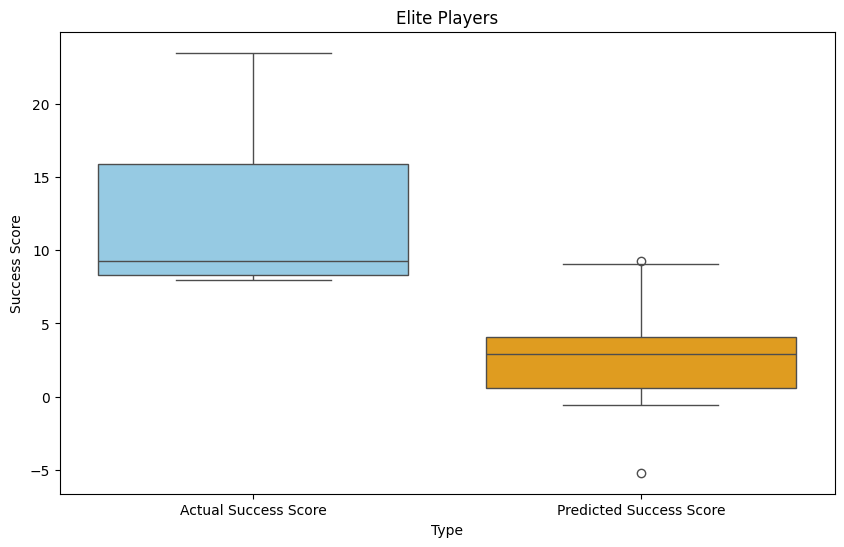

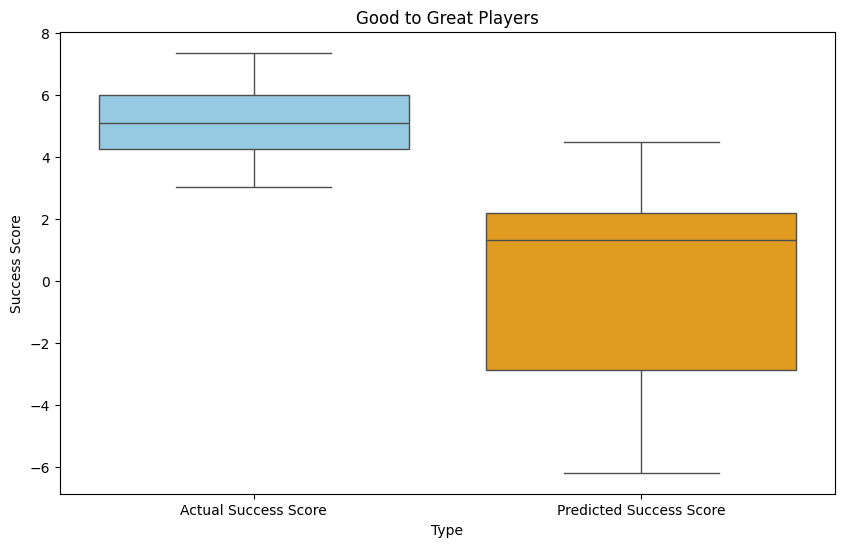

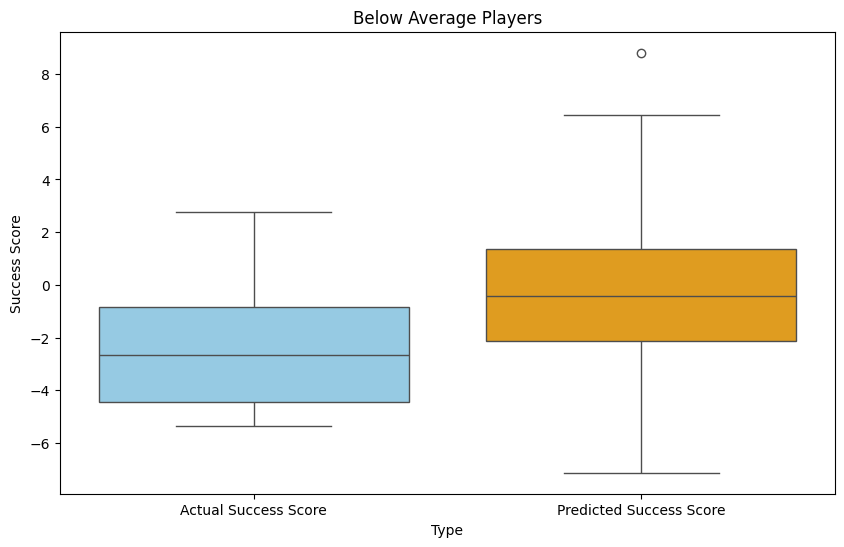

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for box plots
categories = ["Elite", "Good to Great", "Below Average"]

for category in categories:
    # Filter actual and predicted scores for the given category
    actual_scores = [(player, score) for player, score in player_actual_scores.items() if player_actual_categories.get(player) == category]
    predicted_scores = [(player, score) for player, score in player_avg_success_scores.items() if player_predicted_categories.get(player) == category]
    
    # Sort players by actual category
    actual_scores.sort(key=lambda x: x[1], reverse=True)
    predicted_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Extract sorted player names and scores
    players_sorted = [player for player, _ in actual_scores]
    actual_sorted = [score for _, score in actual_scores]
    predicted_sorted = [player_avg_success_scores.get(player, None) for player in players_sorted]
    
    # Convert to DataFrame
    df = pd.DataFrame({"Player": players_sorted, "Actual Success Score": actual_sorted, "Predicted Success Score": predicted_sorted})
    df_melted = df.melt(id_vars=["Player"], var_name="Type", value_name="Success Score")
    
    # Create the box plot for each category
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Type", y="Success Score", data=df_melted, hue="Type", palette={"Actual Success Score": "#89CFF0", "Predicted Success Score": "orange"}, legend=False)
    
    # Labels and title
    plt.ylabel("Success Score")
    plt.title(f"{category} Players")
    
    # Show plot
    plt.show()